In [1]:
import os
from glob import glob
import numpy as np
import dask
import xarray as xr
import xrft
import cartopy.crs as ccrs
from cmocean import cm

from matplotlib import pyplot as plt
%matplotlib inline

from mitequinox.utils import *

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/cmocean/tools.py:76: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not mpl.cbook.is_string_like(rgbin[0]):


In [2]:
from dask_jobqueue import PBSCluster
local_dir = os.getenv('TMPDIR')
cluster = PBSCluster(local_directory=local_dir)
#print(cluster.job_script())
w = cluster.start_workers(20)

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/distributed/utils.py:128: RuntimeWarning: Couldn't detect a suitable IP address for reaching '8.8.8.8', defaulting to '127.0.0.1': [Errno 101] Network is unreachable
  % (host, default, e), RuntimeWarning)


In [3]:
# get dask handles and check dask server status
from dask.distributed import Client
client = Client(cluster)

In [4]:
client

Client Scheduler: tcp://10.148.1.25:56309 Dashboard: http://10.148.1.25:8787/status,Cluster Workers: 34 Cores: 136 Memory: 1700.00 GB


---


# 1. Data files
#### important faces: 1, 2, 4, 5, 7, 8, 10, 11
#### other faces (polar regions): 0, 3, 6, 9, 12

In [4]:
## dir where spectra will be stored
E_dir = '/home1/scratch/xyu/mit_spec/zavg_UV/LLC1080/constant_window/'
print(E_dir)

/home1/scratch/xyu/mit_spec/zavg_UV/LLC1080/constant_window/


In [6]:
face_all = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
D = [xr.open_zarr(E_dir+'E_uv_f%02d_1080.zarr'%(face)) for face in face_all]
ds = xr.concat(D, dim='face')

In [27]:
E_uv_north = ((ds.E_uv).where((ds.YC>0.) & (ds.Depth>500.))).mean(dim=('i','j','face'))   
E_uv_north = np.real(E_uv_north).rename('E_uv_north')
file_E = E_dir+'E_uv_north_allmean_openocean.zarr'  
%time E_uv_north.to_dataset().to_zarr(file_E, mode='w')

CPU times: user 19.2 s, sys: 1.15 s, total: 20.4 s
Wall time: 35.1 s


In [28]:
E_uv_south = ((ds.E_uv).where((ds.YC<0.) & (ds.Depth>500.))).mean(dim=('i','j','face'))   
E_uv_south = np.real(E_uv_south).rename('E_uv_south')
file_E = E_dir+'E_uv_south_allmean_openocean.zarr'  
%time E_uv_south.to_dataset().to_zarr(file_E, mode='w')

CPU times: user 19.4 s, sys: 1.17 s, total: 20.5 s
Wall time: 34.3 s


In [8]:
ds = xr.open_zarr(E_dir+'E_uv_south_allmean_openocean.zarr')
print(ds)

<xarray.Dataset>
Dimensions:            (freq_time: 1440)
Coordinates:
  * freq_time          (freq_time) float64 0.0 1.929e-07 3.858e-07 5.787e-07 ...
    freq_time_spacing  float64 ...
Data variables:
    E_uv_south         (freq_time) float64 dask.array<shape=(1440,), chunksize=(1440,)>


In [9]:
E_south = ds.E_uv_south
E_south = E_south.assign_coords(freq_time=ds.E_uv_south.freq_time * 86400.) 
print(E_south)

<xarray.DataArray 'E_uv_south' (freq_time: 1440)>
dask.array<shape=(1440,), dtype=float64, chunksize=(1440,)>
Coordinates:
  * freq_time          (freq_time) float64 0.0 0.01667 0.03333 0.05 0.06667 ...
    freq_time_spacing  float64 ...


In [10]:
E0_south = E_south/8.64

In [11]:
ds0 = xr.open_zarr(E_dir+'E_uv_north_allmean_openocean.zarr')
print(ds0)

<xarray.Dataset>
Dimensions:            (freq_time: 1440)
Coordinates:
  * freq_time          (freq_time) float64 0.0 1.929e-07 3.858e-07 5.787e-07 ...
    freq_time_spacing  float64 ...
Data variables:
    E_uv_north         (freq_time) float64 dask.array<shape=(1440,), chunksize=(1440,)>


In [12]:
E_north = ds0.E_uv_north
E_north = E_north.assign_coords(freq_time=ds0.E_uv_north.freq_time * 86400.) 
print(E_north)

<xarray.DataArray 'E_uv_north' (freq_time: 1440)>
dask.array<shape=(1440,), dtype=float64, chunksize=(1440,)>
Coordinates:
  * freq_time          (freq_time) float64 0.0 0.01667 0.03333 0.05 0.06667 ...
    freq_time_spacing  float64 ...


In [13]:
E0_north = E_north/8.64

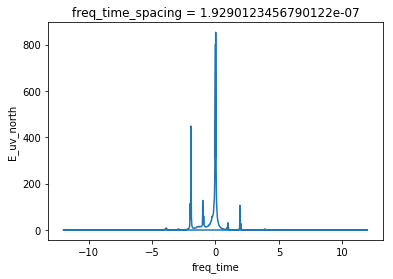

In [14]:
E0_north.plot()

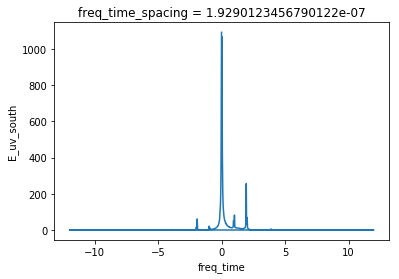

In [15]:
E0_south.plot()

In [16]:
E0_south_anti = E0_south.where(E0_south.freq_time>0)
print(E0_south_anti)

E0_north_anti = E0_north.where(E0_north.freq_time<0)
E0_north_anti = E0_north_anti.assign_coords(freq_time=E_north.freq_time * -1.) 
print(E0_north_anti)

<xarray.DataArray (freq_time: 1440)>
dask.array<shape=(1440,), dtype=float64, chunksize=(1440,)>
Coordinates:
  * freq_time          (freq_time) float64 0.0 0.01667 0.03333 0.05 0.06667 ...
    freq_time_spacing  float64 1.929e-07
<xarray.DataArray (freq_time: 1440)>
dask.array<shape=(1440,), dtype=float64, chunksize=(1440,)>
Coordinates:
  * freq_time          (freq_time) float64 -0.0 -0.01667 -0.03333 -0.05 ...
    freq_time_spacing  float64 ...


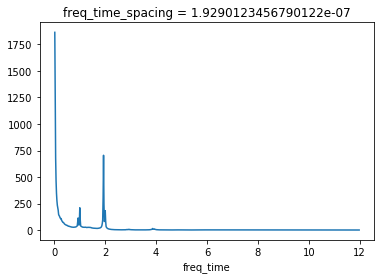

In [17]:
E0_anti = E0_north_anti + E0_south_anti
E0_anti.plot()

In [18]:
E0_south_cycl = E0_south.where(E0_south.freq_time<0)
print(E0_south_cycl)

E0_north_cycl = E0_north.where(E0_north.freq_time>0)
E0_north_cycl = E0_north_cycl.assign_coords(freq_time=E_north.freq_time * -1.) 
print(E0_north_cycl)

<xarray.DataArray (freq_time: 1440)>
dask.array<shape=(1440,), dtype=float64, chunksize=(1440,)>
Coordinates:
  * freq_time          (freq_time) float64 0.0 0.01667 0.03333 0.05 0.06667 ...
    freq_time_spacing  float64 1.929e-07
<xarray.DataArray (freq_time: 1440)>
dask.array<shape=(1440,), dtype=float64, chunksize=(1440,)>
Coordinates:
  * freq_time          (freq_time) float64 -0.0 -0.01667 -0.03333 -0.05 ...
    freq_time_spacing  float64 ...


In [19]:
E0_cycl = E0_north_cycl + E0_south_cycl
E0_cycl = E0_cycl.assign_coords(freq_time=E0_cycl.freq_time * -1.) 

print(E0_cycl)

<xarray.DataArray (freq_time: 1439)>
dask.array<shape=(1439,), dtype=float64, chunksize=(1439,)>
Coordinates:
  * freq_time          (freq_time) float64 -0.0 0.01667 0.03333 0.05 0.06667 ...
    freq_time_spacing  float64 1.929e-07


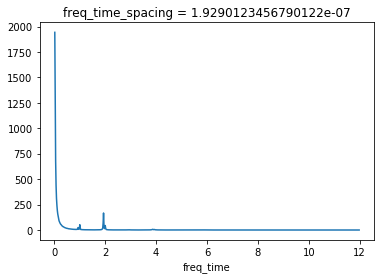

In [20]:
E0_cycl.plot()

In [21]:
E_cycl_all = E0_cycl
E_anti_all = E0_anti

In [22]:
E_cycl_all = np.real(E_cycl_all).rename('E_cycl_all')
file_E = E_dir+'E_cycl_all_openocean.zarr'  
%time E_cycl_all.to_dataset().to_zarr(file_E, mode='w')

CPU times: user 48 ms, sys: 12 ms, total: 60 ms
Wall time: 134 ms


In [23]:
E_anti_all = np.real(E_anti_all).rename('E_anti_all')
file_E = E_dir+'E_anti_all_openocean.zarr'  
%time E_anti_all.to_dataset().to_zarr(file_E, mode='w')

CPU times: user 60 ms, sys: 0 ns, total: 60 ms
Wall time: 135 ms


In [5]:
E_dir = '/home1/scratch/xyu/mit_spec/zavg_UV/LLC1080/constant_window/'
ds_llc_cycl = xr.open_zarr(E_dir+'E_cycl_all_openocean.zarr')
ds_llc_anti = xr.open_zarr(E_dir+'E_anti_all_openocean.zarr')

E_llc_cycl = ds_llc_cycl.E_cycl_all
E_llc_anti = ds_llc_anti.E_anti_all

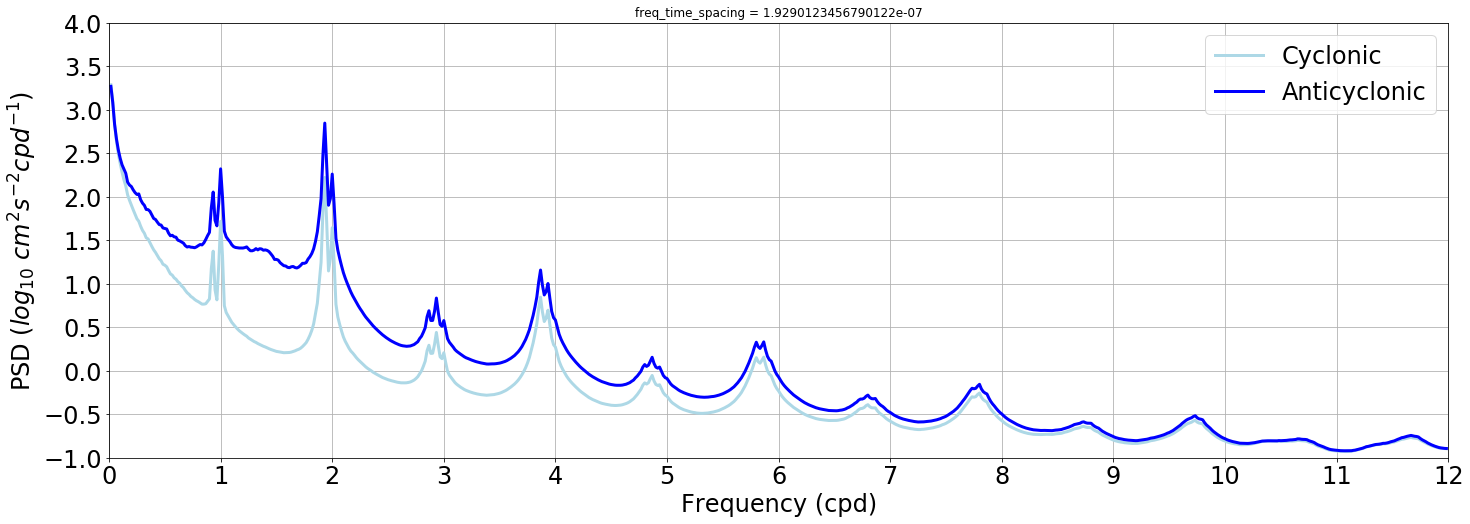

In [34]:

fig, ax = plt.subplots(figsize=(24,8))

labels = ['Cyclonic', 'Anticyclonic']

(np.log10(E_llc_cycl).where(E_llc_cycl.freq_time>0)).plot(ax=ax,color='lightblue', label=labels[0], linewidth=3)
(np.log10(E_llc_anti).where(E_llc_anti.freq_time>0)).plot(ax=ax,color='blue', label=labels[1], linewidth=3)

ax.legend(); ax.grid()
#ax.set_yscale('log')
ax.set_ylim([-1.,4.])
ax.set_yticks([-1, -0.5, 0., 0.5, 1., 1.5, 2., 2.5, 3., 3.5, 4.])

ax.set_xlim([0.,12.])
#ax.set_ylim([1e-1,1e4])


ax.set_xticks([0., 1., 2., 3., 4., 5., 6., 7., 8., 9., 10., 11., 12.])
ax.legend(prop={'size': 24})
ax.set_ylabel('PSD ($log_{10}\ cm^2 s^{-2} cpd^{-1})$',fontsize=24)
ax.set_xlabel('Frequency (cpd)',fontsize=24)
ax.tick_params(labelsize=24)
#ax.set_title('All the world oceans',fontsize=24)


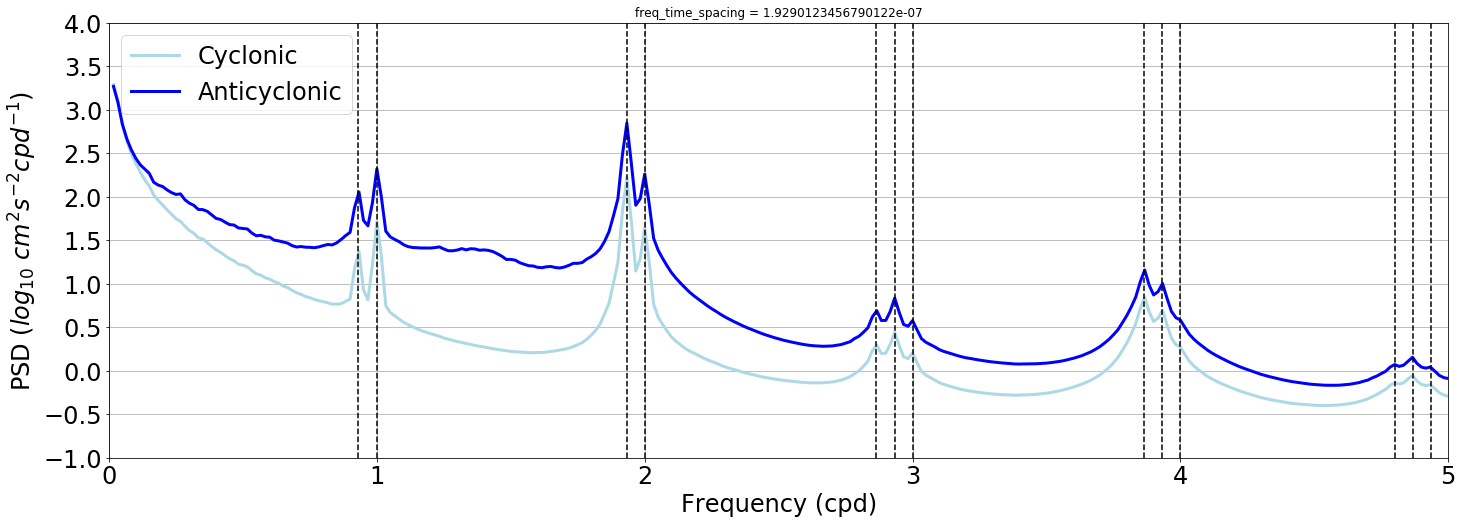

In [10]:

fig, ax = plt.subplots(figsize=(24,8))

labels = ['Cyclonic', 'Anticyclonic']

(np.log10(E_llc_cycl).where(E_llc_cycl.freq_time>0)).plot(ax=ax,color='lightblue', label=labels[0], linewidth=3)
(np.log10(E_llc_anti).where(E_llc_anti.freq_time>0)).plot(ax=ax,color='blue', label=labels[1], linewidth=3)

ax.legend(); ax.grid()
#ax.set_yscale('log')
ax.set_ylim([-1.,4.])
ax.set_yticks([-1, -0.5, 0., 0.5, 1., 1.5, 2., 2.5, 3., 3.5, 4.])

ax.set_xlim([0.,5.])
#ax.set_ylim([1e-1,1e4])


ax.set_xticks([0., 1., 2., 3., 4., 5.])
ax.legend(prop={'size': 24})
ax.set_ylabel('PSD ($log_{10}\ cm^2 s^{-2} cpd^{-1})$',fontsize=24)
ax.set_xlabel('Frequency (cpd)',fontsize=24)
ax.tick_params(labelsize=24)

# Diurnal frequencies
ax.plot([24/25.81933871,24/25.81933871],[-1,1e6],'k--') # O1
ax.plot([1,1],[-1,1e6],'k--') # S1

# Semi-diurnal frequencies
ax.plot([1.93227,1.93227],[-1,1e6],'k--') # M2
ax.plot([2,2],[-1,1e6],'k--') # S2

# 3
ax.plot([2.86181,2.86181],[-1,1e6],'k--') # MO3
ax.plot([2.93501,2.93501],[-1,1e6],'k--') # MK3
ax.plot([3.00274,3.00274],[-1,1e6],'k--') # SK3

# 4
ax.plot([3.86455,3.86455],[-1,1e6],'k--') # M4
ax.plot([3.93227,3.93227],[-1,1e6],'k--') # MS4
ax.plot([4,4],[-1,1e6],'k--') # S4

# 5
ax.plot([4.79956,4.79956],[-1,1e6],'k--') # 3MP5
ax.plot([4.86729,4.86729],[-1,1e6],'k--') # 2MK5
ax.plot([4.93501,4.93501],[-1,1e6],'k--') # MSK5


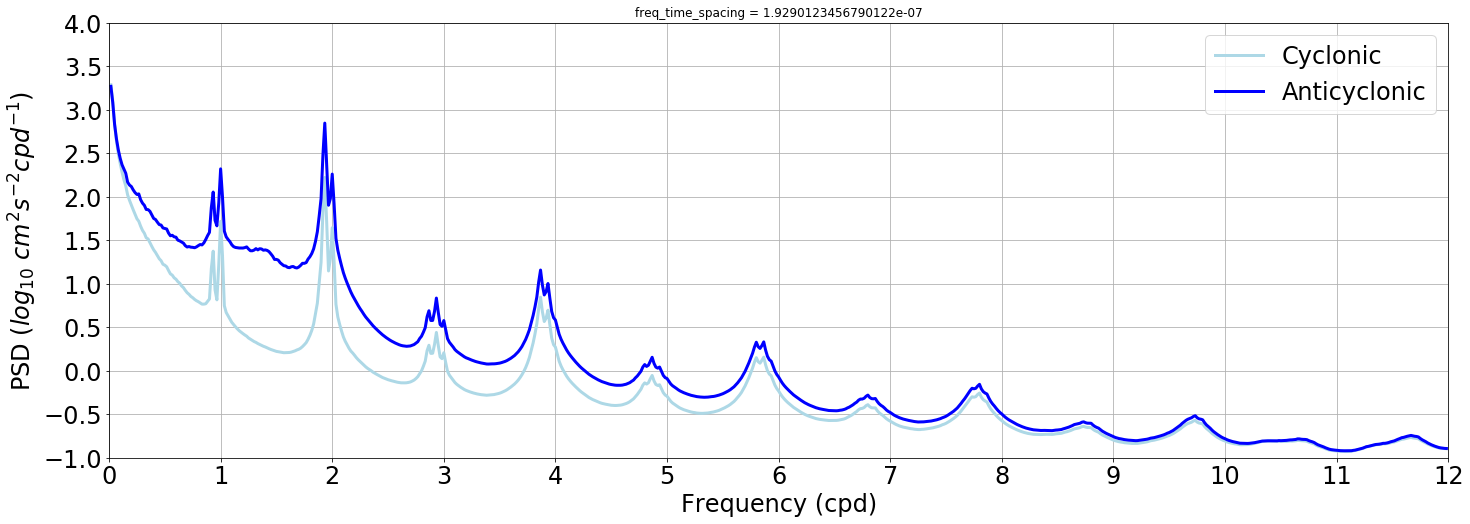

In [34]:

fig, ax = plt.subplots(figsize=(24,8))

labels = ['Cyclonic', 'Anticyclonic']

(np.log10(E_llc_cycl).where(E_llc_cycl.freq_time>0)).plot(ax=ax,color='lightblue', label=labels[0], linewidth=3)
(np.log10(E_llc_anti).where(E_llc_anti.freq_time>0)).plot(ax=ax,color='blue', label=labels[1], linewidth=3)

ax.legend(); ax.grid()
#ax.set_yscale('log')
ax.set_ylim([-1.,4.])
ax.set_yticks([-1, -0.5, 0., 0.5, 1., 1.5, 2., 2.5, 3., 3.5, 4.])

ax.set_xlim([0.,12.])
#ax.set_ylim([1e-1,1e4])


ax.set_xticks([0., 1., 2., 3., 4., 5., 6., 7., 8., 9., 10., 11., 12.])
ax.legend(prop={'size': 24})
ax.set_ylabel('PSD ($log_{10}\ cm^2 s^{-2} cpd^{-1})$',fontsize=24)
ax.set_xlabel('Frequency (cpd)',fontsize=24)
ax.tick_params(labelsize=24)

# Diurnal frequencies
ax.plot([24/25.81933871,24/25.81933871],[1e-2,1e6],'k--') # O1
ax.plot([1,1],[1e-2,1e6],'k--') # S1

# Semi-diurnal frequencies
ax.plot([1.93227,1.93227],[1e-2,1e6],'k--') # M2
ax.plot([2,2],[1e-2,1e6],'k--') # S2

# 3
ax.plot([2.86181,2.86181],[1e-2,1e6],'k--') # MO3
ax.plot([2.93501,2.93501],[1e-2,1e6],'k--') # MK3
ax.plot([3.00274,3.00274],[1e-2,1e6],'k--') # SK3

# 4
ax.plot([3.86455,3.86455],[1e-2,1e6],'k--') # M4
ax.plot([3.93227,3.93227],[1e-2,1e6],'k--') # MS4
ax.plot([4,4],[1e-2,1e6],'k--') # S4

# 5
ax.plot([4.79956,4.79956],[1e-2,1e6],'k--') # 3MP5
ax.plot([4.86729,4.86729],[1e-2,1e6],'k--') # 2MK5
ax.plot([4.93501,4.93501],[1e-2,1e6],'k--') # MSK5

# 6
ax.plot([5.79682,5.79682],[1e-2,1e6],'k--') # M6
ax.plot([5.86455,5.86455],[1e-2,1e6],'k--') # 2MS6
ax.plot([5.93227,5.93227],[1e-2,1e6],'k--') # 2SM6

# 7
ax.plot([6.79956,6.79956],[1e-2,1e6],'k--') # 3MK7
ax.plot([6.86729,6.86729],[1e-2,1e6],'k--') # ST17

# 8
ax.plot([7.72909,7.72909],[1e-2,1e6],'k--') # M8
ax.plot([7.8023,7.8023],[1e-2,1e6],'k--')   # 3MK8
ax.plot([7.86455,7.86455],[1e-2,1e6],'k--') # ST23

# 9
ax.plot([8.73183,8.73183],[1e-2,1e6],'k--') # M4MK9
ax.plot([8.79956,8.79956],[1e-2,1e6],'k--') # ST27


# 10
ax.plot([9.72909,9.72909],[1e-2,1e6],'k--') # ST30
ax.plot([9.79682,9.79682],[1e-2,1e6],'k--') # ST32

# 11
ax.plot([10.7318,10.7318],[1e-2,1e6],'k--') # ST33


# 12
ax.plot([11.6614,11.6614],[1e-2,1e6],'k--') # ST34


In [12]:
cluster.scheduler.close()

<Future finished result=None>